# Examining the lowest 200 m

In [181]:
import urllib.request
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt

data_download=False
### set this to True if running for the first time
if data_download:
    urllib.request.urlretrieve("http://clouds.eos.ubc.ca/~phil/docs/atsc500/tropical_subset.nc", 
                           "tropical_subset.nc")
def do_reynolds(array3d):
    """
    do a spatial-mean reynolds average of a 3d field array3d
    needs dimensions arranged as (z,y,x)
    returns avg(z),perturb(z,y,x)
    """
    avg=array3d.mean(axis=2).mean(axis=1)
    perturb=array3d.T - avg
    perturb=perturb.T
    return avg,perturb

In [182]:
with Dataset('tropical_subset.nc','r') as nc_in:
    print(list(nc_in.variables.keys()))
    the_temp=nc_in.variables['TABS'][0,...]  
    #
    # remove the time dimension since we only have one timestep
    #   
    print('temp shape',the_temp.shape)
    the_height=nc_in.variables['z'][...]
    xvals=nc_in.variables['x'][...]
    yvals=nc_in.variables['y'][...]
    print('height shape',the_height.shape)
    the_press=nc_in.variables['p'][...]
    the_press=the_press*100.  #convert to Pa
    wvel=nc_in.variables['W'][0,...]  #m/s
    qv=nc_in.variables['QV'][0,...]  #vapor g/kg
    ql=nc_in.variables['QN'][0,...]  #liquid  g/kg
  

['x', 'y', 'z', 'time', 'p', 'U', 'V', 'W', 'PP', 'TABS', 'QV', 'QN', 'QP']
temp shape (112, 110, 100)
height shape (112,)


### How much liquid water is in the domain?

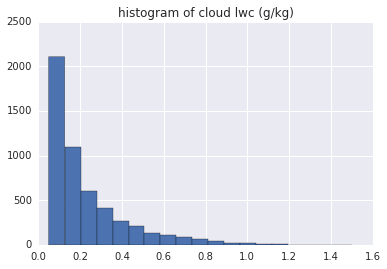

In [183]:
bins=np.linspace(0.05,1.5,20)
out=plt.hist(ql.flat,bins=bins)
plt.title('histogram of cloud lwc (g/kg)')

# Plotting three $h_m$ profiles

What does $h_m = c_p T + l_v q_v + gz$ look like in the boundary layer?

## Zoom in on bottom 200 m

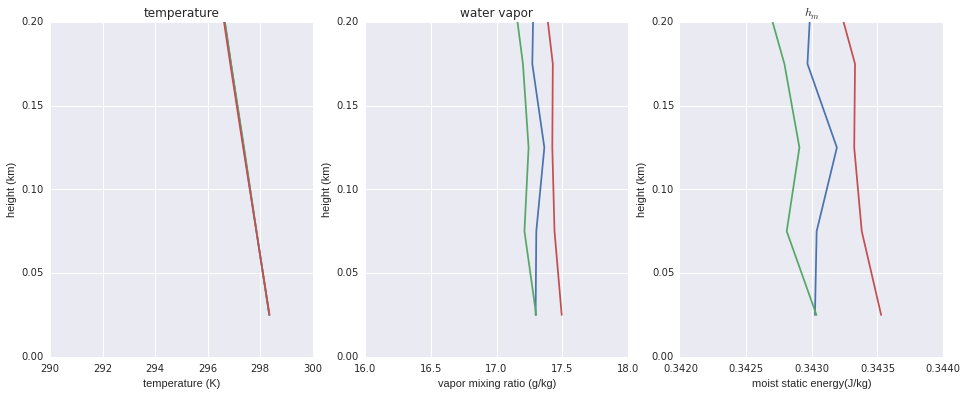

In [184]:
%matplotlib inline
#
# plot 3 arbitrary columns
#
from matplotlib import pyplot as plt
meter2km=1.e-3
lv=2.5e6
g=9.8
cpd=1004.
random_xy=[(10,20),(80,40),(25,75)]
fig,ax=plt.subplots(1,3,figsize=(16,6))
for x,y in random_xy:
    temp_profile=the_temp[:,y, x]
    qv_profile=qv[:,y, x]
    hm_profile = cpd*temp_profile + lv*qv_profile*1.e-3 + g*the_height
    out=ax[0].plot(temp_profile,the_height*meter2km) 
    out=ax[1].plot(qv_profile,the_height*meter2km) 
    out=ax[2].plot(hm_profile*1.e-6,the_height*meter2km) 
out=ax[0].set(xlabel='temperature (K)',ylabel='height (km)',title='temperature')
ax[0].set(xlim=(290,300))
ax[1].set(xlim=(16,18))
ax[2].set(xlim=(0.342,0.344))
out=ax[1].set(xlabel='vapor mixing ratio (g/kg)',ylabel='height (km)',title='water vapor')
out=ax[2].set(xlabel='moist static energy(J/kg)',ylabel='height (km)',title='$h_m$')
for the_ax in ax:
    the_ax.set(ylim=(0,0.2))

## Temps in the lowest layer layers are highly homogenous but there is slighlty greater variability in vapor mixing ratio which translates in greater variablity in moist static energy.  These variations are much lowere below the cloud layer than they are at higher values of z though


# Calculate the temperature and vapor fluxes

In [185]:
Rd=287  #J/kg/K
g2kg = 1.e-3
qv_avg,qv_perturb=do_reynolds(qv)
temp_avg,temp_perturb=do_reynolds(the_temp)
rho_avg=the_press/(Rd*temp_avg)
w_avg,w_perturb = do_reynolds(wvel)
T_flux=((w_perturb*temp_perturb).T*rho_avg).T*cpd  #W/m^2
qv_flux=((w_perturb*qv_perturb).T*rho_avg).T*lv*g2kg #W/m^2
T_flux_1d=(T_flux).mean(axis=2).mean(axis=1)
qv_flux_1d=(qv_flux).mean(axis=2).mean(axis=1)

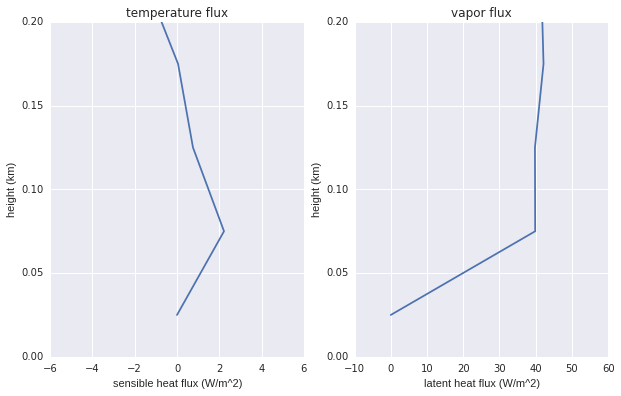

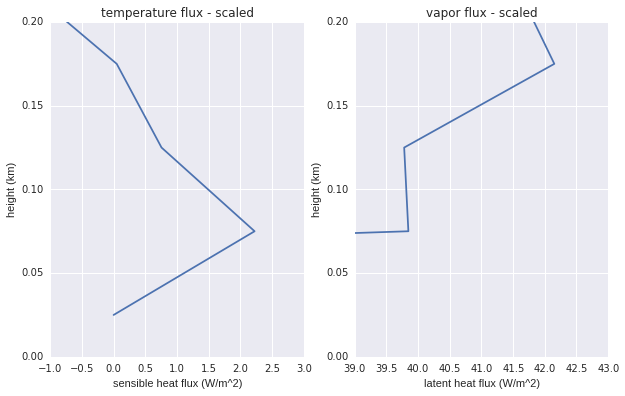

In [186]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].plot(T_flux_1d,the_height*meter2km)  
ax[0].set(xlabel='sensible heat flux (W/m^2)',ylabel='height (km)',title='temperature flux')
ax[1].plot(qv_flux_1d,the_height*meter2km)  
out=ax[1].set(xlabel='latent heat flux (W/m^2)',ylabel='height (km)',title='vapor flux')
out=[the_ax.set(ylim=(0,0.2)) for the_ax in ax]

fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].plot(T_flux_1d,the_height*meter2km)  
ax[0].set(xlabel='sensible heat flux (W/m^2)',ylabel='height (km)',title='temperature flux - scaled')
ax[1].plot(qv_flux_1d,the_height*meter2km)  
out=ax[1].set(xlabel='latent heat flux (W/m^2)',ylabel='height (km)',title='vapor flux - scaled')
out=[the_ax.set(ylim=(0,0.2)) for the_ax in ax]
out=ax[0].set(xlim=(-1,3))
out=ax[1].set(xlim=(39,43))

### Vapor flux is of a much graeater magnitue than the temp flux and they both display less variablity in this layer than in the cloud layer.
    At first glance the temp profile seemd to display greater variablity (excluding the initil jump from zero to 40 in the first two layers due to reasons previously discussed in class), but that was due to the scaling of the plots.  
    
    I scaled both plots to a 4 w/m^2 interval to more directly compare them, and it becomes apparent that the vapor flux does vary (by about 3 w/m^2) with height below the cloud layer as well.

## Closer examination of fluxes at 200 m

Mean Sensible Heat Flux =  -1.51381
Mean Latent Heat Flux =  41.5115


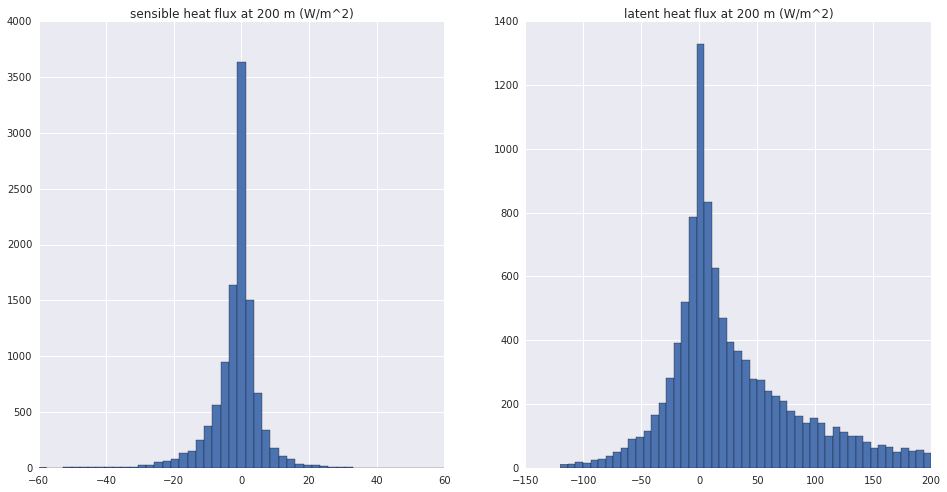

In [187]:
#
# select the level closest to 800 meters
# using searchsorted
#
zlev=np.searchsorted(the_height,200)
ql_800 = ql[zlev,:,:] == 0.
T_flux_800 = T_flux[zlev,:,:] #W/m^2
qv_flux_800 = qv_flux[zlev,:,:] #W/m^2
fig,ax = plt.subplots(1,2,figsize=(16,8))
print('Mean Sensible Heat Flux = ',T_flux800.mean())
print('Mean Latent Heat Flux = ',qv_flux800.mean())
out=ax[0].hist(T_flux_800.flat,bins=np.linspace(-60,60,50))
out=ax[1].hist(qv_flux_800.flat,bins=np.linspace(-120,200,50))
ax[0].set(title='sensible heat flux at 200 m (W/m^2)')
ax[1].set(title='latent heat flux at 200 m (W/m^2)')

####  Sensible heat flux at 200 m is of a lower magnitude than 800 m (mean ~ 1.5 w/m^2 lower) with more values concentrated around zero, though it maintains its ~ normal distribution.  

#### Latent heat flux at 200 m also displays a lower magintued than 800 m (as this is where the profile maxima is experienced - mean ~ 8w/m^2 lower).  However, there are also fewere negative values with a with a slightly fatter positive tail (at least to 200 w/m^2).  Since this is below the cloud layer there are fewer cool downdrafts associated with cloud formation and phase change (ie. evaportational cooling) which cause greater # of negative values

I think the two sets of histograms in the example were plotting he same thing just with different bin sizes?  So I only included one.


## Here's what happens when I don't limit the flux ranges

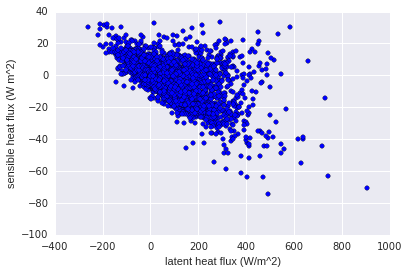

In [188]:
fig,ax=plt.subplots(1,1)
ax.scatter(qv_flux800.flat,T_flux800.flat)
ax.set(xlabel=r'latent heat flux (W/m^2)',ylabel=r'sensible heat flux (W m^2)')

### There are still some large values, up to ~ 900 w/m^2 latent heat flux & sensible heat flux of ~ -70 but the nike swoosh shape of 800 m is gone, the values are more densly clustered, and closer to zero.  Since it is below the cloud layer, were are not seeing the anomolously high values associated with condensational warming.

In [189]:
out=np.where(qv_flux800 > 500)
#
#  unpack out into two individual lists and zip, then turn back
#  into a list
#
flux_list=list(zip(*out))
for item in flux_list:
    print(item)

(22, 90)
(32, 20)
(34, 92)
(44, 77)
(51, 58)
(63, 93)
(67, 87)
(84, 52)
(87, 34)
(90, 84)
(93, 66)
(93, 92)
(94, 62)
(94, 91)
(94, 92)
(95, 62)
(95, 84)
(99, 26)
(101, 43)
(102, 2)
(102, 42)


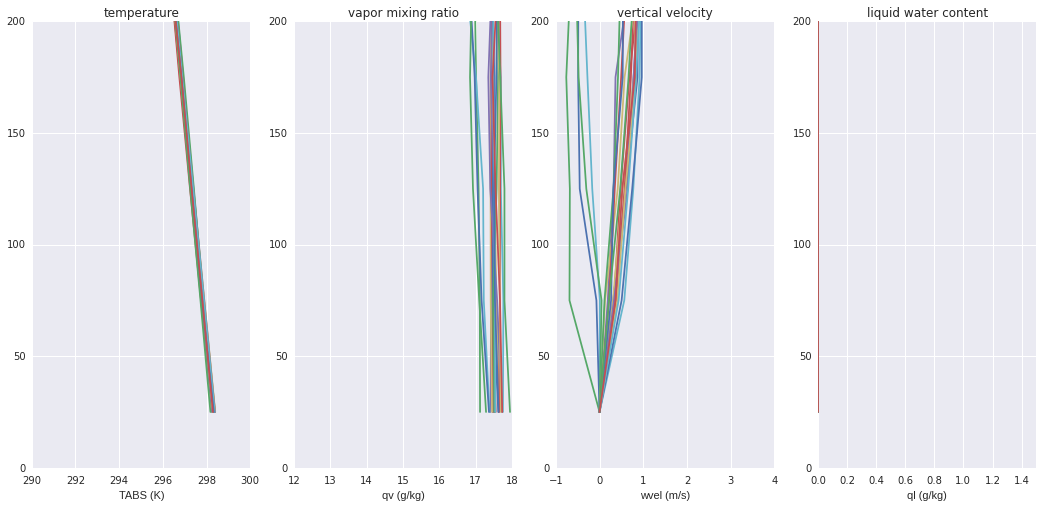

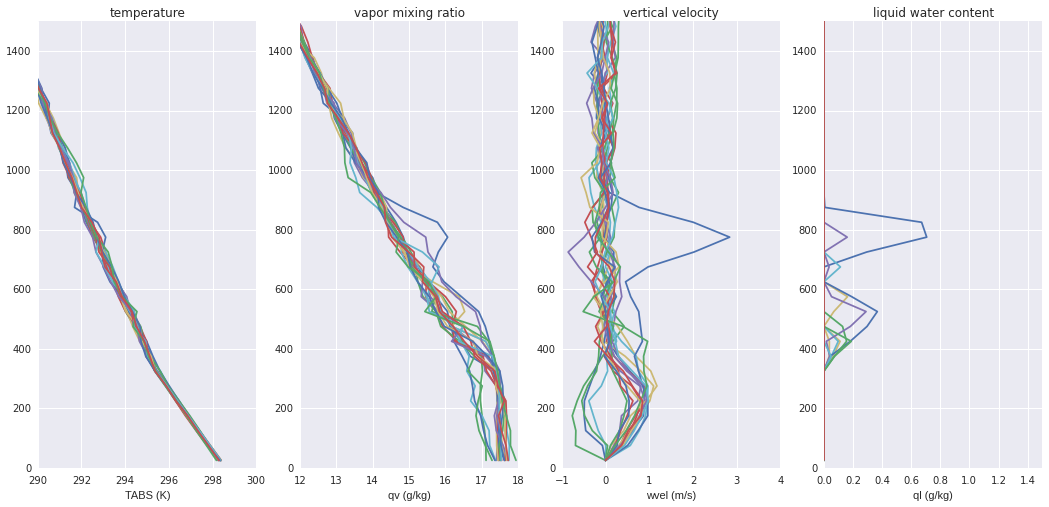

In [190]:
fig,ax=plt.subplots(1,4,figsize=(18,8))
for y,x in flux_list:
    ax[0].plot(the_temp[:,y,x],the_height)
    ax[1].plot(qv[:,y,x],the_height)
    ax[2].plot(wvel[:,y,x],the_height)
    ax[3].plot(ql[:,y,x],the_height)
ax[0].set(xlim=(290,300),xlabel='TABS (K)',title='temperature')
ax[1].set(xlim=(12,18),xlabel='qv (g/kg)',title='vapor mixing ratio')
ax[2].set(xlim=(-1,4),xlabel='wvel (m/s)',title='vertical velocity')
ax[3].set(xlim=(0,1.5),xlabel='ql (g/kg)',title='liquid water content')
out=[the_ax.set(ylim=(0,200)) for the_ax in ax]
fig,ax=plt.subplots(1,4,figsize=(18,8))

for y,x in flux_list:
    ax[0].plot(the_temp[:,y,x],the_height)
    ax[1].plot(qv[:,y,x],the_height)
    ax[2].plot(wvel[:,y,x],the_height)
    ax[3].plot(ql[:,y,x],the_height)
ax[0].set(xlim=(290,300),xlabel='TABS (K)',title='temperature')
ax[1].set(xlim=(12,18),xlabel='qv (g/kg)',title='vapor mixing ratio')
ax[2].set(xlim=(-1,4),xlabel='wvel (m/s)',title='vertical velocity')
ax[3].set(xlim=(0,1.5),xlabel='ql (g/kg)',title='liquid water content')
out=[the_ax.set(ylim=(0,1500)) for the_ax in ax]

##  I changed the above code to look at the anomolusly high latent heat fluxes (values over ~ 500)

###  Not supprisingly the liquid water content = 0 since we are below the cloud level and the temp profile is highly uniform like the example for 800 m.  The vappor mixing ratio and vertical velocity display slightly more variablity.

### When the plot is expanded to 1500 m, we can see greater spread in the vapor mixing ratio and expecially the vertical velocity.  It is also apparent that some (but not all!) of the columns devlop clouds at higher levels.  It is interesting to not that not all the columns with anomolus latent heat fluxes at 200 m develop clouds higher up.  I'm guessing this is primarily due to the effects of horizontal advection.

# joint distributions


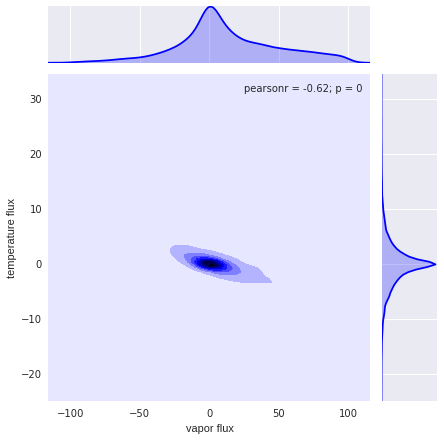

In [191]:
import seaborn as sns
#
#  limit the range f the data to be plotted
#
hit=((qv_flux800 > -100) & (qv_flux800 < 100)) &( (T_flux800 > -50) & (T_flux800 < 50))
g=sns.jointplot(x=qv_flux800[hit].flat,y=T_flux800[hit].flat,kind='kde',color='blue')
ax=g.ax_joint
ax.set(xlabel='vapor flux',ylabel='temperature flux')

### Similar to the previoulsy noted trends, the values are peakier, with a slightly more postive skew to the vapor flux and slightly weaker covariance

### Writing our own histogram routine

There are a lot of cases where it's useful to roll our own histograms.  For example,
here's a $w^\prime$  $T^\prime$ plot with a lot of points

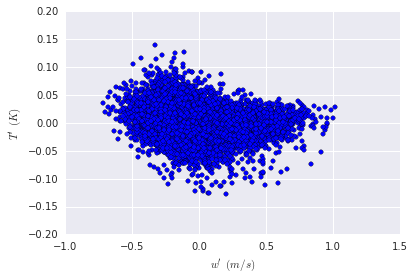

In [192]:
fig,ax=plt.subplots(1,1)
temp_perturb = temp_perturb[zlev,:,:] #W/m^2
w_perturb = w_perturb[zlev,:,:] #W/m^2
ax.scatter(w_perturb,temp_perturb)
ax.set(xlabel=r'$w^\prime\ (m/s)$',ylabel=r'$T^\prime\ (K)$')

### Even more densly cluster around zero further necessitation the use of a personalized histogram routine

#### as an aside - it tooke mee a while to figure out I needed to do

temp_perturb = temp_perturb[zlev,:,:]

#### I spent a while scratching my head wondering why my plots looked exactly like the exapmle!


In [193]:
from importlib import reload
import a500_code.hist_numba
out=reload(a500_code.hist_numba)
from a500_code.hist_numba import hist2d
print(help(hist2d))

Help on function hist2d in module a500_code.hist_numba:

hist2d(x_raw, y_raw, x_edges, y_edges)
    Produce a 2-d histogram (for example, of temperature (y) vs.
      vertical velocity (x) data)  binned into temperature,wvel
      bins
    input: row_raw,col_raw: data vectors of the row variable (temperature)
           and the column variable (wvel)
           col_edges, row_edges:  coordinates of the bin edges for each variables
    returns:  counts,col_centers,row_centers
    
    Example, given 10,000 temperature measurements to be binned into 20 bins, and
             20,000 wvel measurements to be binned into 10 bins, return
             counts as a [20,10]  array with the number of measurements that fall
             into each bin

None


### Now redo the wvel, T scatterplot as a 2-d histogram, plotting log10(counts)

in numba 6


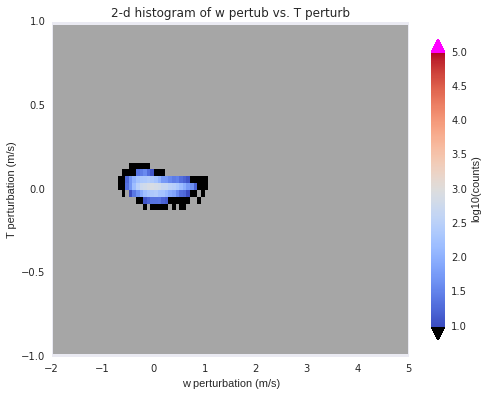

In [194]:

from matplotlib.colors import Normalize
wedges=np.linspace(-2,5,100)
Tedges=np.linspace(-1,1,50)
counts,row_centers,col_centers=hist2d(w_perturb.ravel(), 
                                       temp_perturb.ravel(),wedges,Tedges)
mask=np.isnan(counts)
counts=np.ma.array(counts,mask=mask)
fig,ax=plt.subplots(1,1,figsize=(8,6))
#
# we want to map 256 colors from the coolwarm palette  into the
# data range log10(counts) = 1 to log10(counts) = 5  (i.e. 10 to 100,000)
#
#  we also want to color empty bins grey, and show all bins that aren't empty
#  but fall outside of the range as either black (less than 10 counts) or magenta
#  (more than 100,000) counts
#
cmap=plt.get_cmap('coolwarm')
cmap.set_under('black')
cmap.set_over('magenta')
cmap.set_bad('0.65')
the_norm=Normalize(vmin=1,vmax=5)
cs=ax.pcolormesh(row_centers,col_centers,np.log10(counts),cmap=cmap,norm=the_norm)
ax.set(xlabel='w perturbation (m/s)',ylabel='T perturbation (m/s)',
       title='2-d histogram of w pertub vs. T perturb')
cbar=fig.colorbar(cs,shrink=0.9,extend='both')
cbar.ax.set(ylabel='log10(counts)')

## The perturbation values are much lower.  Centered much more closely around zero.  At this level it is expected that the vertical velocity variations would be lower, therefore resulting in lowere differences in temperature as well.   *provided homogenous surface conditions ... if one were to make a model with an inhomogenous surface i think temp perturbations at low elevation could be higher?

[(40, 51),

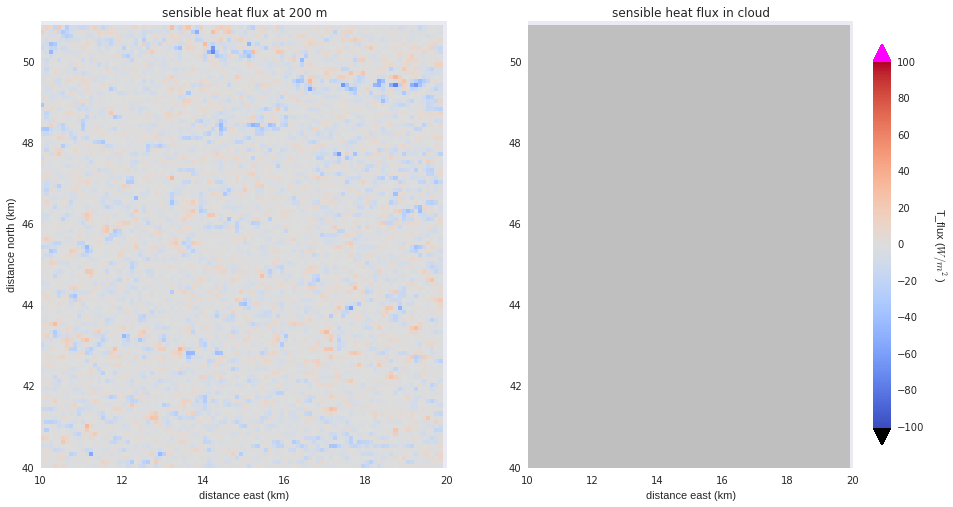

In [195]:
#
#  Make a color imaged with a scaled colormap
#
#
# also get the cloud liquid water field at the same level
#
ql_800=ql[zlev,:,:]*lv*rho_avg[zlev]  #g/kg
# center the colorbar about 0
#
the_norm=Normalize(vmin=-100,vmax=100)

cmap=plt.get_cmap('coolwarm')
cmap.set_under('black')
cmap.set_over('magenta')
cmap.set_bad('0.75')
fig,ax=plt.subplots(1,2,figsize=(16,8))
cs=ax[0].pcolormesh(xvals*1.e-3,yvals*1.e-3,T_flux_800,cmap=cmap,norm=the_norm)
ax[0].set(ylim=(40,51),xlabel='distance east (km)',ylabel='distance north (km)',
          title='sensible heat flux at 200 m')
cbar=fig.colorbar(cs,shrink=0.9,extend='both')
out=cbar.ax.set(ylabel='T_flux ($W/m^2$)')
out[0].set(rotation=-90,va='bottom')
#
#  hide pixels with no liquid water
#
hit=ql_800 < 1.e-2
T_flux_masked=np.ma.array(T_flux_800,mask=hit)
cs=ax[1].pcolormesh(xvals*1.e-3,yvals*1.e-3,T_flux_masked,cmap=cmap,norm=the_norm)
ax[1].set(ylim=(40,51),title='sensible heat flux in cloud',xlabel='distance east (km)')

### Obviously, there is not sensible heat flux in the could since we are below the cloud level.  The hosziontal distribution of sesnible heat fluxes is more uniform and mute.  There still apper to be regional maxima and minima (the NE corner for intance)  but there is a lot more grey here, representing less activity

# Cloud fraction calcuation!!!!!

In [196]:
Cloud = np.greater(ql,0)
Cloud_Count = Cloud.sum(axis = 2).sum(axis = 1)
Cloud_Frac = Cloud_Count/(float(Cloud.shape[1])*float(Cloud.shape[2]))

# Cloud Fraction plot

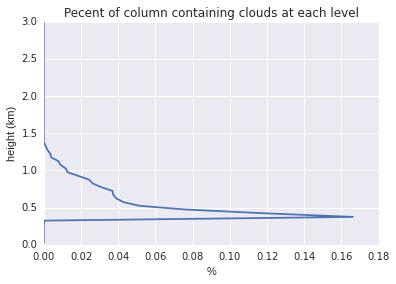

In [197]:
fig,ax=plt.subplots(1,1)
ax.plot(Cloud_Frac,the_height*meter2km)  
ax.set(xlabel='%',ylabel='height (km)',title='Pecent of column containing clouds at each level')
out=ax.set(ylim=(0,3))


## There is a sharp peak in cloud fraction around 400 or 450 m from zero to the maxima of 16% representing the LCL.  This maximum is very thin as the fraction quickly decrease to ~ 4% by 600 m.  From here the decrease is more gradual up to about 1.2 km where clouds cease to exist.  There is a high concentration of shallow clouds around 450 m and then fewer, deeper clouds that extend up to higher elevations. 

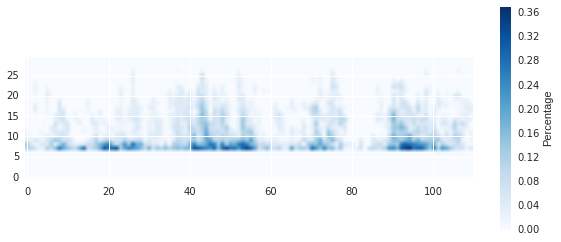

In [198]:
import matplotlib.cm as cm

Cloud = np.greater(ql,0)
Cloud_Count = Cloud.sum(axis = 2)
Cloud_Frac = Cloud_Count/(float(Cloud.shape[2]))
fig,ax=plt.subplots(1,1,figsize=(10,4))
ax = plt.imshow(Cloud_Frac[0:30,:],cmap=cm.Blues, origin = "lower")
cb1 = plt.colorbar(ax)
cb1.set_label('Percentage')


#  Just for fun & to test my idea that there were some deeper clouds veruses just other, disjointed clouds at higher elevations, I sumed over just the x axis and ploted the 2d cloud fraction.  The plumes make visible, make me think there are some deep clouds, though i can't fully prove it without a 3d visualization.